In [1]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import OriginLink, URDFLink

In [10]:
np.degrees(1.1345)

np.float64(65.0020618575919)

In [11]:
# В URDF, единицы измерения являются метры и радианы
# TODO: погрешности в устанавливаемом угле и размерах (но с моделью и на реальной руке образ можно сказать совподает)
robot_chain = Chain(name='robot_arm', links=[
    URDFLink(
        name="base",
        bounds=(-np.pi/2, np.pi/2), # от -90 до 90
        origin_translation=[0, 0, 0],
        origin_orientation=[0, 0, 0],
        rotation=[0, 0, 1],
    ),
    # Первое звено (соединение с базой, плечо)
    URDFLink(
        name="shoulder",
        bounds=(-np.pi/2, np.pi/2),
        origin_translation=[0, 0, 0.02],
        origin_orientation=[0, 0, 0],
        rotation=[0, -1, 0],
    ),
    # Второе звено (локоть)
    URDFLink(
        name="elbow",
        bounds=(-np.pi/2, np.pi/2),
        origin_translation=[0, 0, 0.105],
        origin_orientation=[0, 0, 0],
        rotation=[0, 1, 0],
    ),
    # Третье звено (запястье)
    URDFLink(
        name="wrist",
        bounds=(-np.pi/2, np.pi/2),
        origin_translation=[0, 0, 0.096],
        origin_orientation=[0, 0, 0],
        rotation=[0, 1, 0],
    ),
    # Четвертое звено (крутит захват)
    URDFLink(
        name="wrist_rotational",
        bounds=(-np.pi/2, np.pi/2),
        origin_translation=[0, 0, 0.065],
        origin_orientation=[0, 0, 0],
        rotation=[0, 0, 1],
    ),
    # Манипулятор (захват)
    URDFLink(
        name="gripper",
        bounds=None,
        origin_translation=[0, 0, 0.11],
        origin_orientation=[0, 0, 0],
        rotation=None,
        joint_type='fixed',
    )
])

c:\projects\robot_manipulator\env\Lib\site-packages\ikpy\chain.py:60: UserWarning: Link gripper (index: 5) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))


In [26]:
0.02 + 0.105 + 0.096 + 0.065 + 0.11

0.396

Передом считаем где перед манипулятором металическая платформа

pwm 10 = 90, значит вправо будет уменьшение угла, влево увеличение
pwm 11 = 115, значит наклон вперед будет уменьшение угла, назад увеличение
pwm 12 = 98, значит наклон вперед будет увеличение угла, назад уменьшение
pwm 13 = 74, значит наклон вперед будет увеличение угла, назад уменьшение
pwm 14 = 90, значит поворот клешни влевл будет увеличение угла, вправо уменьшение
pwm 15 = 142, закрытый - уменьшаем угл открываем

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

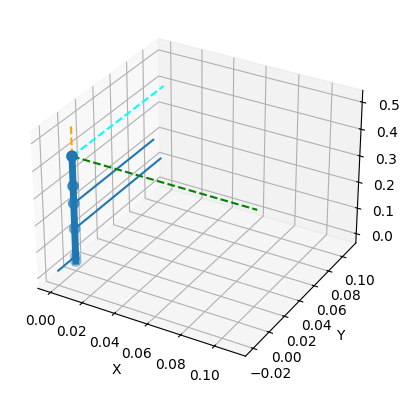

In [12]:
ax = plt.figure().add_subplot(111, projection='3d')

angles_radians = robot_chain.inverse_kinematics([0, 0, 0])

robot_chain.plot(angles_radians, ax, show=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# joint_angles_degrees = np.degrees(angles_radians)
# angles_text = "\n".join([f"{link.name}: {angle:.2f}°" for link, angle in zip(robot_chain.links, joint_angles_degrees)])
# ax.text2D(0.05, 0.95, f"Angles Chains:\n{angles_text}", transform=ax.transAxes, fontsize=10,
#           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# ax.grid(True)

plt.show()

In [13]:
angles_radians = robot_chain.inverse_kinematics([0.15, -0.05, 0.15])
angles_radians

array([-0.32175055,  0.40554829,  0.76588388,  1.53810719,  0.        ,
        0.        ])

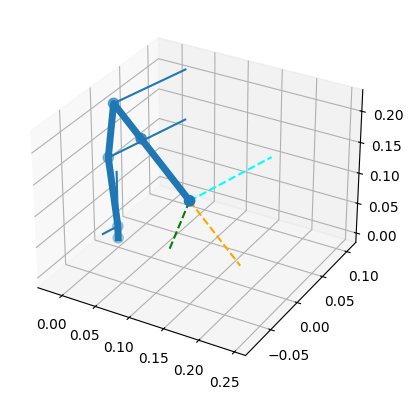

In [7]:
ax = plt.figure().add_subplot(111, projection='3d')
robot_chain.plot(angles_radians, ax, show=False)
plt.show()

In [14]:
angles_degrees = np.degrees(angles_radians)
angles_degrees

array([-18.43494882,  23.23620548,  43.88191413,  88.12705042,
         0.        ,   0.        ])

71.5 113.2 133.8 178.1 90

Значения сервов при x = 0.15 y = -0.05, z = 0.1
pwm10 90 - 18 = 72
pwm11 115 + 22.2 = 137.2
pwm12 98 + 55.4 = 153.4
pwm13 74 + 90.7 = 164.7

Значения сервов при x = 0.15 y = -0.05 z = 0.05
pwm10 90 - 19 = 71
pwm11 115 + 24.9 ~= 140
pwm12 98 + 78 = 176
pwm13 74 + 80 = 154

Значения сервов при x = 0.1 y = 0.05 z = 0.0 (то есть поворот вправо)
pwm10 90 - 26 = 64
pwm11 115 + 19 = 134
pwm12 98 + 81 = 179
pwm13 74 + 96 = 170

Значения сервов при x = 0.1 y = -0.05 z = 0.0 (то есть поворот влево) погрешность по x ~= 0.01 по y ~= 0.02
pwm10 90 + 26 = 116
pwm11 115 - 19 = 96
pwm12 98 + 81 = 179
pwm13 74 + 96 = 170

In [30]:
# Параметры траектории восьмерки
width = 0.1
shift = 0.2
points_number = 100
t = np.linspace(0, 2 * np.pi, points_number) 
x = [shift] * points_number
y = width * np.sin(2 * t) + shift
z = width * np.sin(t) + shift

# Генерация точек траектории
target_positions = np.vstack((x, y, z)).T

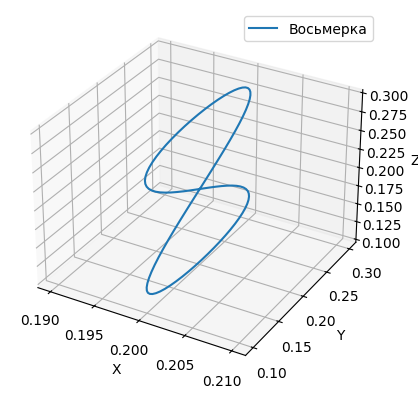

Позиция 0: [ 0.78539816 -0.37571405  0.44319013  0.65600771  0.          0.        ]
Позиция 1: [ 0.81606578 -0.46620892  0.38501213  0.55148249  0.          0.        ]
Позиция 2: [ 0.84440726 -0.57203893  0.32521466  0.41646601  0.          0.        ]
Позиция 3: [ 0.8702105  -0.71017573  0.26562287  0.21136764  0.          0.        ]
Позиция 4: [ 8.93352973e-01 -9.99472223e-01  1.19913940e-05 -1.04572289e-05
  0.00000000e+00  0.00000000e+00]


In [32]:
from matplotlib import animation


# учитываем только подвижные суставы
# active_links = [link for link in robot_chain.links if link.rotation is not None]
# initial_position = [0] * len(active_links)
initial_position = [0, 0, 0]

# Список для хранения углов суставов
joint_angles = []

for idx, target in enumerate(target_positions):
    
    # Вычисление углов суставов
    angles = robot_chain.inverse_kinematics(target_position=target)
    
    # Проверка на достижимость точки
    if angles is not None:
        joint_angles.append(angles)
        initial_position = angles  # обновляем начальное положение для следующей итерации
    else:
        print(f"Точка {idx} недостижима: {target}")
        joint_angles.append(initial_position)  # сохраняем предыдущее положение

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Восьмерка')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

for i, angles in enumerate(joint_angles[:5]):
    print(f"Позиция {i}: {angles}")

robot_chain.plot(joint_angles[-1], ax, show=False)
plt.show()

# Анимация движения робо-руки
# def update_plot(num, joint_angles, robot_chain, ax):
#     ax.cla()
#     robot_chain.plot(joint_angles[num], ax, show=False)
#     # plot_utils.plot(robot_chain, joint_angles[num], ax=ax, target=target_positions[num])
#     ax.set_xlim(shift - width - 0.1, shift + width + 0.3)
#     ax.set_ylim(shift - width - 0.1, shift + width + 0.3)
#     ax.set_zlim(shift - width - 0.1, shift + width + 0.3)
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title(f'Позиция {num}')

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(
#     fig, 
#     update_plot, 
#     frames=len(joint_angles), 
#     fargs=(joint_angles, robot_chain, ax),
#     interval=100, 
#     repeat=True
# )

# plt.show()

In [34]:
angles_degrees = np.degrees(joint_angles)

angles: [ 45.         -21.52682947  25.39292413  37.58647298   0.
   0.        ]


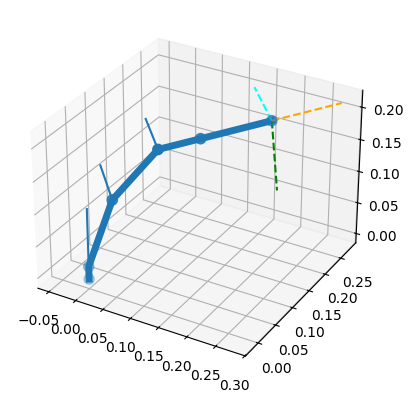

In [67]:
ax = plt.figure().add_subplot(111, projection='3d')

print(f"angles: {angles_degrees[0]}")
robot_chain.plot(joint_angles[0], ax, show=False)
plt.show()

In [62]:
for i, angles in enumerate(angles_degrees[:5]):
    print(f"Позиция {i}: {angles}")

Позиция 0: [ 45.         -21.52682947  25.39292413  37.58647298   0.
   0.        ]
Позиция 1: [ 46.75712513 -26.71180368  22.05956991  31.59761927   0.
   0.        ]
Позиция 2: [ 48.38097235 -32.77541648  18.6334274   23.86174489   0.
   0.        ]
Позиция 3: [ 49.85938869 -40.69007204  15.21906933  12.1104737    0.
   0.        ]
Позиция 4: [ 5.11853550e+01 -5.72655401e+01  6.87056269e-04 -5.99155080e-04
  0.00000000e+00  0.00000000e+00]
